In [1]:
# requires seaborn, pandas

In [2]:
import uuid
from datetime import datetime
import logging
from tqdm import tqdm
import io

import seaborn as sns
import pandas as pd
import dns.message
import dns.query
import dns.flags
from dns.rdatatype import SOA, TXT, RRSIG, A, AAAA, MX, NSEC3
from dns.rdataclass import IN

logging.basicConfig(level=logging.ERROR, force=True)

sns.set(font_scale=2)
sns.set_style('whitegrid')

def query(qname, rdtype) -> dns.message.Message:
    q = dns.message.make_query(
        qname=qname, rdtype=rdtype, want_dnssec=True, use_edns=0,
    )
    q.flags |= dns.flags.AD
    logging.debug(q.to_text())
    start = datetime.now()
    try:
        r = dns.query.tcp(q, where='127.0.0.1', port=5301, timeout=1)  # auth NS
    except dns.exception.Timeout:
        return None, None
    return r, (datetime.now() - start).total_seconds()

In [15]:
# test configuration
samples = 10**4

In [16]:
# do measurements

seen_nsec3onames = set()

def random_nx_query(algorithm):
    name = dns.name.from_text(f"{algorithm}3.example.")
    qname = dns.name.from_text(f"{str(uuid.uuid4())}", origin=name)
    rdtype = MX  # we don't have any MX records
    r, query_time = query(qname, rdtype)
    assert r.get_rrset(dns.message.ANSWER, qname, IN, rdtype) == None
    new_nsec3onames = {rrset.name - name for rrset in r.sections[2] if rrset.rdtype == NSEC3 and rrset.rdclass == IN} - seen_nsec3onames
    seen_nsec3onames.update(new_nsec3onames)
    return {
        'algorithm': algorithm,
        'qname': qname,
        'query_time': query_time,
        'response': r,
        'new_nsec3onames': new_nsec3onames,
        'new_nsec3s': [rrset for rrset in r.sections[2] if rrset.rdtype == NSEC3 and rrset.name - name in new_nsec3onames],
        'new_rrsigs': [rrset for rrset in r.sections[2] if rrset.rdtype == RRSIG and rrset.name - name in new_nsec3onames],
    }

query_times = pd.DataFrame(
    [random_nx_query(algorithm) for _ in tqdm(range(samples)) for algorithm in ["falcon"]]
)

100%|██████████| 10000/10000 [00:37<00:00, 263.95it/s]


In [17]:
# save measurements
filename = f"data/measurements-nsec3narrow-{samples:n}-{datetime.now().strftime('%Y-%m-%d-%H-%M')}.pickle"
query_times.to_pickle(filename)

In [18]:
# load data and prepare
query_times = pd.read_pickle(filename)
query_times['query_time_ms'] = 1000 * query_times['query_time']

# filter for queries with one new signature
query_times = query_times[
    query_times['new_nsec3onames'].apply(len) == 1
][[
    'algorithm',
    'new_nsec3s',
    'new_rrsigs',
    'query_time_ms',
]].copy()

# unpack arrays
query_times['new_nsec3'] = query_times['new_nsec3s'].apply(lambda x: x[0])
del query_times['new_nsec3s']
query_times['new_rrsig'] = query_times['new_rrsigs'].apply(lambda x: x[0])
del query_times['new_rrsigs']

# extract messages and signatures
def message(row):
    # see https://www.rfc-editor.org/rfc/rfc4034#section-3.1.8.1
    rrsig_rdata = row['new_rrsig'][0].to_wire()[:-len(row['new_rrsig'][0].signature)]

    f = io.BytesIO()
    row['new_nsec3'].to_wire(f)
    rr1 = f.getvalue()

    return rrsig_rdata + rr1

query_times['message'] = query_times.apply(message, axis=1)
query_times['signature'] = query_times['new_rrsig'].apply(lambda x: x[0].signature)

In [19]:
query_times

,algorithm,query_time_ms,new_nsec3,new_rrsig,message,signature
1,falcon,3.996,(1 0 0 - lv0f93gpecft4souf34hhlokt5ggeu4p),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,b'9\x83\x12\x8ew\xcb\xdd\x98\x8e.\xd0n\xd8h\x8...
2,falcon,4.077,(1 0 0 - 35b4jirl1jonq1oao042du41l4upuf2c),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,b'9I9\xb4?C\x01\xc11\x83\xc6u\xd6\x97\x10=\xb8...
3,falcon,3.994,(1 0 0 - mpv2au667tl6gmnamlvv33jq37ld0fjd),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,b'9\xd6X\xca\x96\r|\xd9\xe4s\xf6\x00Y\xb6q\xe8...
4,falcon,3.773,(1 0 0 - l0fb1ka1935265m7p6aidos1d37pnn1p),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,b'9\xbf\x1a\x9bB\x91\xe3\xaf/ :\xb8\xf9\x1cH\x...
5,falcon,3.818,(1 0 0 - b77r6ltii5g3r1mpnbjc3q7hos3snsap),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,b'9lB\xb8\xb0\xc2\x83\xdf\xeeT\xb8.\x12\xac\xf...
...,...,...,...,...,...,...
9995,falcon,3.225,(1 0 0 - o90pqfjggk74m8ighnrfmtk3v3aojtql),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,b'95\xe6\xcb\xc9\xc3\xad\xba?`\x11Y\xbe\xa9<\x...
9996,falcon,3.176,(1 0 0 - dqmgd4m8mcce7lpghq80662c0s1f8abg),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,"b'9wr\xbb\xc2""\xe7\xd7\xa3\xf81XIQ\\\xbd\x0c+X..."
9997,falcon,3.281,(1 0 0 - qe6r9tju42spes4no15ee4gj9ba11om0),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,b'9\x8f\r\x95\x16\xcd@\xdbn10~\x05\xb5\xce\xad...
9998,falcon,3.363,(1 0 0 - 81da3qvfphnvo9msl0p5hou3gktto3m0),(NSEC3 17 3 3600 20220901000000 20220811000000...,b'\x002\x11\x03\x00\x00\x0e\x10c\x0f\xf6\x00b\...,"b'9\xe4@\x97\x80\xa1,\xc0\x19Ora\xac\'\x8e\xc3..."


In [20]:
#%%bash
#docker-compose exec -T auth pdnsutil export-zone-key ed255193.example 7

In [21]:
#from cryptography.hazmat.primitives.asymmetric.ed25519 import Ed25519PrivateKey
#import base64
#private_key = Ed25519PrivateKey.from_private_bytes(base64.b64decode("eiajnduVQEgnfnoIbklw7T2SNyffZ6Hbw5MRnuDjhdo="))
#query_times['check_signature'] = query_times['message'].apply(private_key.sign)

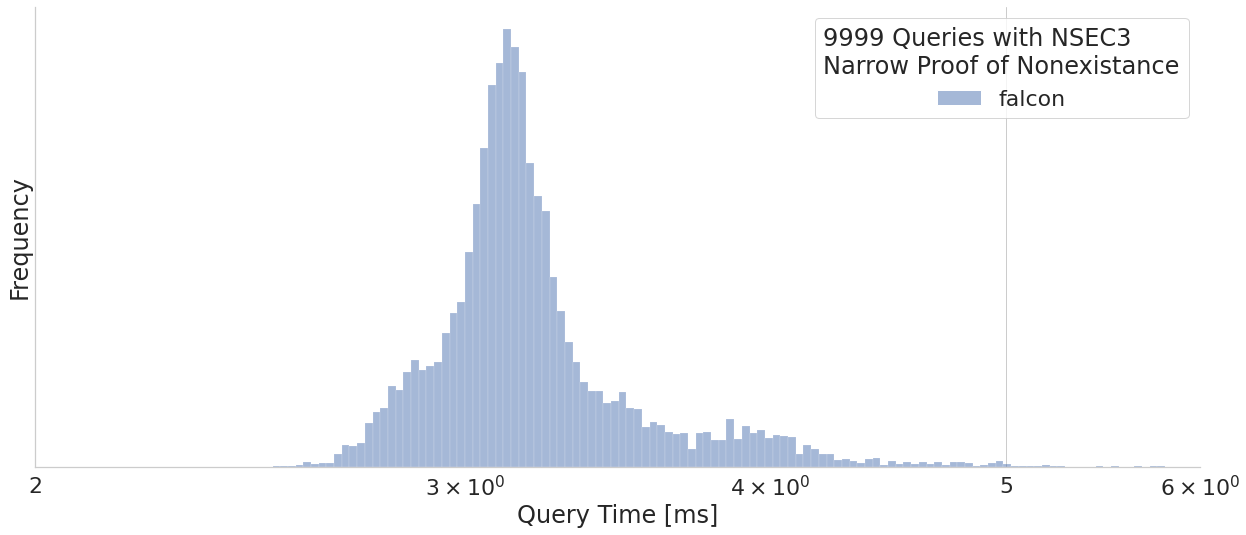

In [26]:
# visualize
g = sns.displot(
    query_times,
    x='query_time_ms', hue='algorithm', 
    log_scale=(True, False),
    height=8,
    aspect=18/8,
    facet_kws=dict(legend_out=False),
    kind='hist',
)
g.set(
    xlim=(2, 6), 
    xlabel='Query Time [ms]', 
    ylabel='Frequency', 
    yticks=[],
    xticks=[2,5],
    xticklabels=[2,5],
)
g.legend.set_title(f'{len(query_times)} Queries with NSEC3\nNarrow Proof of Nonexistance')
g.savefig('data/query_times.pdf')